### Introduction

In this workflow, we will show spatial clustering and cluster analysis techniques applied to segmented nuclei from H&E WSI. Using nuclei segmentations, we identify and analyze spatial patterns of immune cell aggregates and their relationship to tissue structures. This is useful for understanding the spatial organization of immune cells in the tumor microenvironment, which can provide insights into immune response related questions such as immune activation, infiltration etc. Note that this workflow is not limited to immune cells, it can be applied to any type of spatially distributed objects, such as collagen fibers, stromal cells, etc.

Key steps include:

- Density-based clustering to identify immune cell aggregates.
- Extraction of cluster features such as neighborhood densitiy, size, area, dispersion, and orientation.
- Visualization of clusters and their centroids.
- Classifying clusters into Lymphoid aggregates and potential TLSs based on simple heuristics.
- Analysis of cluster proximity to different tissue types.

Let's start by loading the example data.

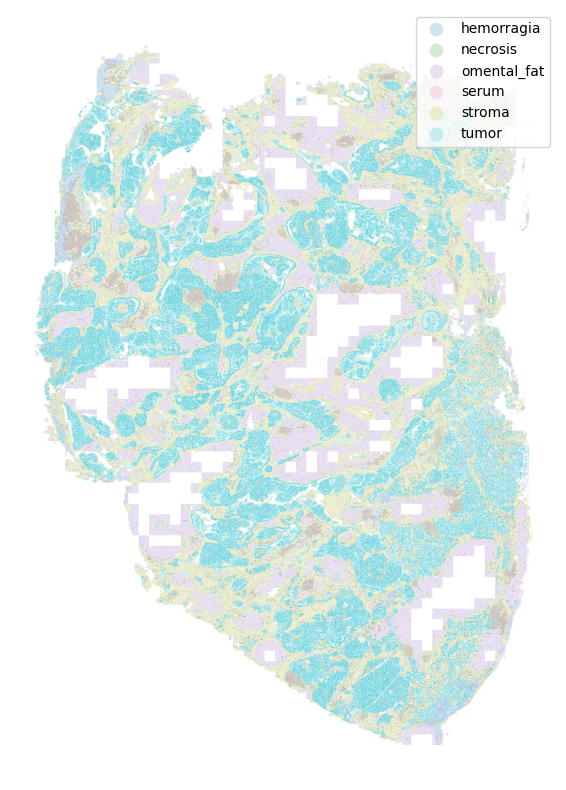

In [1]:
from histolytics.data import hgsc_nuclei_wsi, hgsc_tissue_wsi

nuc = hgsc_nuclei_wsi()
tis = hgsc_tissue_wsi()

ax = tis.plot(figsize=(10, 10), column="class_name", alpha=0.2, aspect=1, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1)
ax.set_axis_off()

### Clustering Inflammatory Cells with DBSCAN

We'll set the minimum number of samples in the clusters to 100 and the maximum distance between samples to 250px (125 microns).

geometry    class_name  labels
uid                                                                         
86   POLYGON ((547 37896.992, 547 37901.985, 551.99...  inflammatory      -1
94   POLYGON ((701 37928.983, 705.993 37933.976, 71...  inflammatory      -1
98   POLYGON ((625 37499.992, 625.999 37511.982, 63...  inflammatory      -1

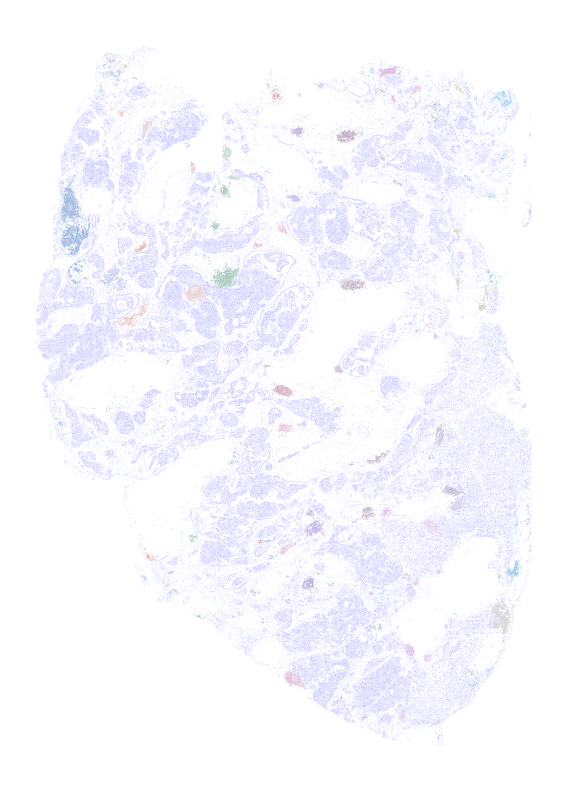

In [2]:
from histolytics.spatial_clust.density_clustering import density_clustering

nuc_imm = nuc[nuc["class_name"] == "inflammatory"]
labels = density_clustering(nuc_imm, eps=250, min_samples=100, method="dbscan")
nuc_imm = nuc_imm.assign(labels=labels)

ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
ax.set_axis_off()
nuc_imm.head(3)

The immune cell clusters are highlighted with different colors in the image. These clusters represent either Lymphoid Aggregates (Laggs) or more mature tertiary lymphoid structures (TLS). 

### Cluster Neighborhood Densities

The most likely interpretation of each cluster can be derived from its spatial characteristics, such as size, shape, density and the existence of germinal centers which would indicate a more organized structure typical of TLS. Germinal centers can be hard to identify in some clusters, and additional analysis may be required to confirm their presence, but we can easily compute the size and neighborhood densities for each cluster and set a threshold heuristic to determine whether a cluster is a Lagg or a TLS (typically TLS are larger and denser). First, we'll compute the neighborhood densities.

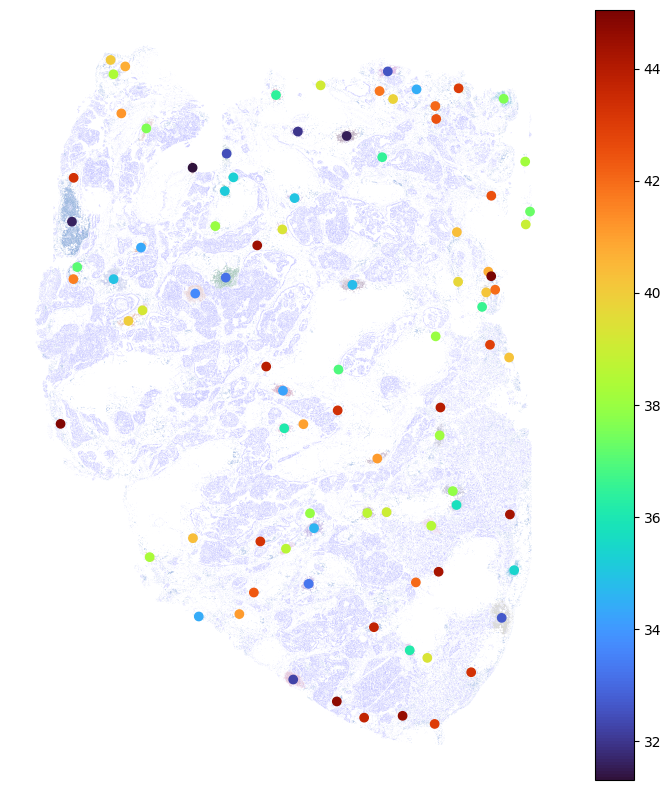

In [16]:
from histolytics.spatial_agg.local_distances import local_distances
from histolytics.spatial_graph.graph import fit_graph
import pandas as pd
from histolytics.spatial_clust.centrography import cluster_tendency
import geopandas as gpd

# Get the clustered immune nuclei. Let's set an id col so we can track each cell id at global level
clustered_nuc_imm = (
    nuc_imm[nuc_imm["labels"] != -1]
    .reset_index(drop=False)
    .rename(columns={"uid": "id"})
)

# let's fit a delaunay graph on each immune cluster to compute nhood distances
cluster_graphs = []
for i in clustered_nuc_imm["labels"].unique():
    cluster = clustered_nuc_imm[clustered_nuc_imm["labels"] == i]
    w, w_gdf = fit_graph(cluster, "delaunay", threshold=250, id_col=None)
    dists = local_distances(cluster, w, id_col=None)
    cluster_graphs.append(dists)

# get cluster centroids
clust_centroids = (
    nuc_imm.groupby("labels")
    .apply(lambda g: cluster_tendency(g, "mean"), include_groups=False)
    .reset_index(drop=False, name="geometry")
)

# get mean nhood distances per cluster
nhood_dists = pd.concat(cluster_graphs).reset_index(drop=True)
nhood_dists = (
    nhood_dists.groupby("labels")
    .apply(lambda x: x["nhood_dists_mean"].mean(), include_groups=False)
    .sort_values(ascending=False)
)
nhood_dists.name = "nhood_dists_mean"

# merge the cluster centroids and nhood distances
clust_feats = clust_centroids.merge(nhood_dists, on="labels")

# convert to GeoDataFrame
clust_feats = gpd.GeoDataFrame(clust_feats, geometry="geometry")

# plot
ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats.plot(ax=ax, column="nhood_dists_mean", aspect=1, cmap="turbo", legend=True)
ax.set_axis_off()

### Compute Cluster Areas

Next, we will compute the areas of the clusters. The `cluster_feats` function also computes the cluster area, dispersion and orientation for each cluster but we'll leave those features untouched for now and use only the cluster densities and areas for our analysis.

In [ ]:
from histolytics.spatial_clust.clust_metrics import cluster_feats
import pandas as pd
import geopandas as gpd


# compute the cluster sizes (number of cells in each cluster)
clust_sizes = (
    clustered_nuc_imm.groupby("labels")
    .apply(
        lambda x: pd.Series(
            cluster_feats(x, hull_type="convex_hull", normalize_orientation=True)
        ),
        include_groups=False,
    )
    .reset_index(drop=False)
)
# merge the cluster centroids and features
clust_feats = clust_feats.merge(clust_sizes, on="labels")
clust_feats.head(5)

labels                     geometry  nhood_dists_mean          area  \
0        0   POINT (2432.115 30375.571)         44.931122  3.348646e+05   
1        1   POINT (3508.768 49500.988)         31.615201  1.653666e+07   
2        2   POINT (3647.298 44067.835)         41.627359  1.130964e+06   
3        3   POINT (4007.447 45206.206)         37.056731  1.262858e+06   
4        4   POINT (3669.009 53649.081)         43.285193  1.303155e+05   
..     ...                          ...               ...           ...   
85      85  POINT (44933.734 21806.188)         44.318124  3.499691e+05   
86      86  POINT (44859.741 36651.431)         40.267456  1.522813e+05   
87      87  POINT (46434.795 49237.848)         38.968171  2.432185e+05   
88      88  POINT (46836.496 50458.293)         37.290687  3.192059e+05   
89      89  POINT (46379.693 55183.825)         38.136915  1.521591e+05   

     dispersion     size  orientation  
0    210.071704    163.0     6.179763  
1   1853.488920  12115.0    89.351878  
2    473.763588    494.0    40.110577  
3    435.069616    760.0    42.858025  
4    148.194226     83.0    83.120009  
..          ...      ...          ...  
85   238.108933    181.0     8.879174  
86   157.504400    107.0    69.020158  
87   203.606138    155.0    40.041493  
88   232.912662    225.0    89.920400  
89   180.376885    122.0    89.290457  

[90 rows x 7 columns]

### TLS Heuristic

Now we'll create a crude heuristic for identifying potential TLS (Tertiary Lymphoid Structures) based on the cluster features we've computed. This heuristic will be based on a combination of cluster area and density. The bigger and denser the cluster is, the more likely it is to be a TLS.

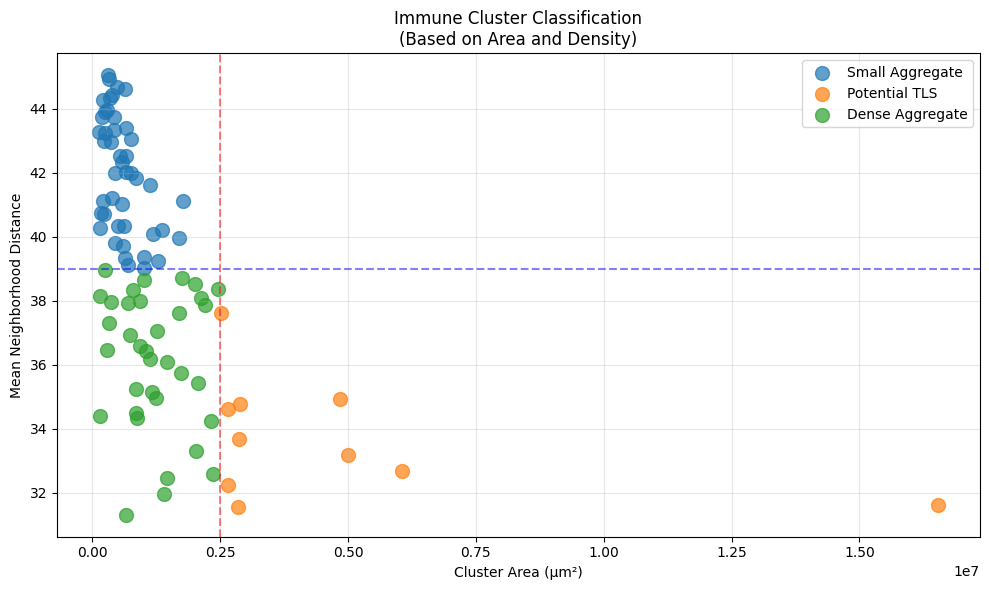


Cluster Classification Results:
cluster_type
Small Aggregate    45
Dense Aggregate    35
Potential TLS      10
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Add a simple classification based on size and density
def classify_clusters(df, area_threshold=2500000, density_threshold=None):
    """Simple heuristic classification"""
    if density_threshold is None:
        density_threshold = df["nhood_dists_mean"].median()

    conditions = [
        (df["area"] > area_threshold) & (df["nhood_dists_mean"] < density_threshold),
        (df["area"] > area_threshold) & (df["nhood_dists_mean"] >= density_threshold),
        (df["area"] <= area_threshold) & (df["nhood_dists_mean"] < density_threshold),
        (df["area"] <= area_threshold) & (df["nhood_dists_mean"] >= density_threshold),
    ]

    choices = ["Potential TLS", "Large Aggregate", "Dense Aggregate", "Small Aggregate"]

    df["cluster_type"] = np.select(conditions, choices, default="Unclassified")
    return df


# Apply classification
clust_feats_classified = classify_clusters(clust_feats.copy())

# Plot with classification
plt.figure(figsize=(10, 6))
for cluster_type in clust_feats_classified["cluster_type"].unique():
    mask = clust_feats_classified["cluster_type"] == cluster_type
    plt.scatter(
        clust_feats_classified.loc[mask, "area"],
        clust_feats_classified.loc[mask, "nhood_dists_mean"],
        label=cluster_type,
        s=100,
        alpha=0.7,
    )

plt.xlabel("Cluster Area (μm²)")
plt.ylabel("Mean Neighborhood Distance")
plt.title("Immune Cluster Classification\n(Based on Area and Density)")
plt.legend()
plt.grid(True, alpha=0.3)

# Add threshold lines
plt.axvline(x=2500000, color="red", linestyle="--", alpha=0.5, label="Area Threshold")
plt.axhline(
    y=clust_feats["nhood_dists_mean"].median(),
    color="blue",
    linestyle="--",
    alpha=0.5,
    label="Density Threshold",
)

plt.tight_layout()
plt.show()

# Print classification results
print("\nCluster Classification Results:")
print(clust_feats_classified["cluster_type"].value_counts())

Let's visualize clusters and cluster centroids. We will highlight the potetial cluster type.

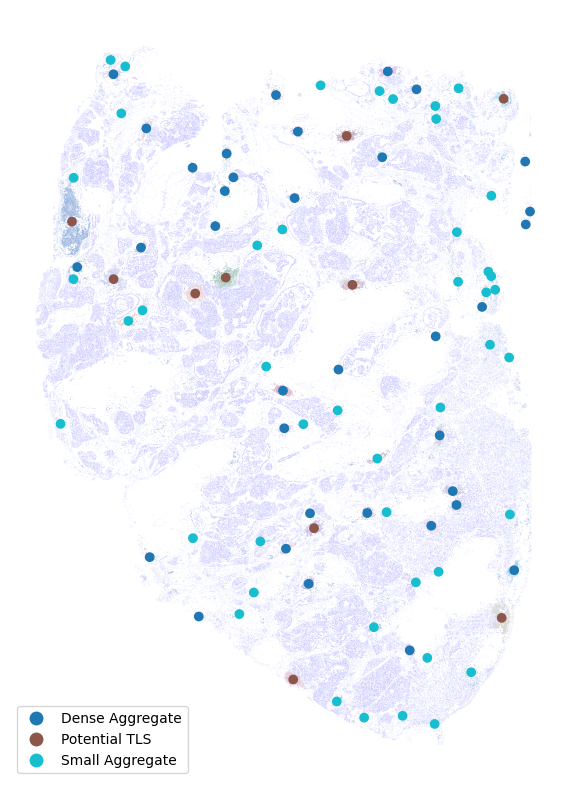

In [ ]:
ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats_classified.plot(
    ax=ax, column="cluster_type", aspect=1, cmap="tab10", legend=True
)
ax.set_axis_off()

### Cluster Centroid Distances to Different Tissues

Let's now calculate the distances of the cluster centroids to different tissue types. This can help in understanding how the clusters are distributed in relation to the tissue types. We use the `cluster_dists_to_tissue` function for this purpose and measure the immune cluster centroid distances to other tissues. We will measure the centroid distances to tumor and omental fat tissues in this example.

labels                    geometry  nhood_dists_mean          area  \
0       0  POINT (2432.115 30375.571)         44.931122  3.348646e+05   
1       1  POINT (3508.768 49500.988)         31.615201  1.653666e+07   
2       2  POINT (3647.298 44067.835)         41.627359  1.130964e+06   
3       3  POINT (4007.447 45206.206)         37.056731  1.262858e+06   
4       4  POINT (3669.009 53649.081)         43.285193  1.303155e+05   

    dispersion     size  orientation     cluster_type  dist_to_tumor  \
0   210.071704    163.0     6.179763  Small Aggregate     470.562404   
1  1853.488920  12115.0    89.351878    Potential TLS    1109.971779   
2   473.763588    494.0    40.110577  Small Aggregate     392.835793   
3   435.069616    760.0    42.858025  Dense Aggregate     786.064771   
4   148.194226     83.0    83.120009  Small Aggregate     614.856948   

   dist_to_omental_fat          closest_tissue  distance_to_tissue  
0           684.283897        closest_to_tumor          470.562404  
1            27.871655  closest_to_omental_fat           27.871655  
2            63.166603  closest_to_omental_fat           63.166603  
3             0.000000  closest_to_omental_fat            0.000000  
4           165.602860  closest_to_omental_fat          165.602860

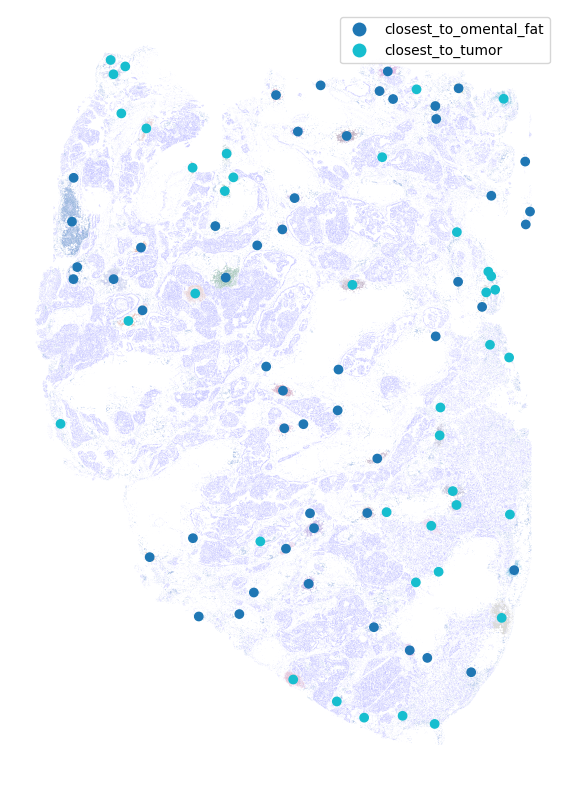

In [ ]:
from histolytics.spatial_clust.clust_metrics import cluster_dists_to_tissue

# get the distances to the tissue classes
clust_feats_classified = cluster_dists_to_tissue(clust_feats_classified, tis, "tumor")
clust_feats_classified = cluster_dists_to_tissue(
    clust_feats_classified, tis, "omental_fat"
)

# get the closest tissue class
clust_feats_classified["closest_tissue"] = (
    clust_feats_classified[["dist_to_tumor", "dist_to_omental_fat"]]
    .idxmin(axis=1)
    .str.replace("dist_to", "closest_to")
)

# # get the distance to the closest tissue class
clust_feats_classified["distance_to_tissue"] = clust_feats_classified[
    ["dist_to_tumor", "dist_to_omental_fat"]
].min(axis=1)


ax = nuc.plot(figsize=(10, 10), color="blue", alpha=0.3, aspect=1)
ax = nuc_imm.plot(ax=ax, column="labels", aspect=1, cmap="tab20")
clust_feats_classified.plot(
    ax=ax, column="closest_tissue", legend=True, aspect=1, cmap="tab10"
)
ax.set_axis_off()
clust_feats_classified.head(5)

In [32]:
clust_feats_classified.value_counts("closest_tissue")

closest_tissue
closest_to_omental_fat    51
closest_to_tumor          39
Name: count, dtype: int64

In the example, we can see that most of the inflammatory cluster centroids reside closer to omental fat tissue than the tumor itself. However, from this example, it is hard to conclude anything from this alone. The main purpose was to demonstrate that this type of analysis can be conducted in a straightforward manner and it can be useful for understanding the spatial relationships between immune clusters and different tissue types in other contexts. Naturally, this analysis can be extended to include other tissue types as well.

### Conclusions

In this workflow, we have demonstrated how to perform spatial clustering and cluster analysis of segmented inflammatory nuclei from H&E WSI. We used density-based clustering to identify immune cell aggregates, computed cluster features, and visualized the clusters and their centroids. Additionally, we used a heuristic to classify the clusters based on their features, providing a way to identify potential Tertiary Lymphoid Structures (TLS) within the tissue and we explored the spatial relationships between these clusters and different tissue types.